***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


***

In [4]:
from copy import deepcopy
import gc
import dill
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tqdm import tqdm
import yaml
import shap

from sklearn import preprocessing
import category_encoders as ce
import lightgbm as lgb
from tsforest.forecast import LightGBMForecaster

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor
from features import Featurador


In [5]:
SEED = 19
SUB_NBR = 30
print(SUB_NBR)

30


In [6]:
np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [7]:
with open(f"../data/skus_assess_m1.yaml", "r") as file:
    skus_assess_m1 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m1): {len(skus_assess_m1)}")
    file.close()

with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    print(f"len(skus_assess_m2): {len(skus_assess_m2)}")
    file.close()
    
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values
print(f"len(skus_for_test): {len(skus_for_test)}")

len(skus_assess_m1): 482635
len(skus_assess_m2): 272130
len(skus_for_test): 551472


In [8]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")

    dataset = (
        pd.read_parquet(f"{input_path}/train-m1.parquet")
        .query("sku in @skus_assess_m1")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
    with open("../encoders/encoder-stg1.dill", "rb") as file:
        encoder = dill.load(file)
        file.close()
    
    transformed = encoder.transform(dataset[encoder.cols].astype("category"))
    for col in transformed.columns:
        dataset[col+"_glm"] = transformed[col].values

In [9]:
if ASSESS:
    raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
    metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
    raw = pd.merge(raw, metadata, how="inner", on="sku")

    # compute q_mean and q_std features (w/o leakage)
    feat = Featurador(raw)
    feat.fit(left_limit="2021-02-01", right_limit="2021-03-01")
    dataset = feat.transform(dataset)

In [10]:
if ASSESS:
    raw = raw.query("'2021-02-01' <= date <= '2021-03-01'").reset_index(drop=True)
    raw["had_sales"] = raw.eval("sold_quantity > 0")
    raw["was_active"] = raw.eval("minutes_active > 120")

    sales_rate = (raw.groupby("sku")["had_sales"].sum() / raw.groupby("sku")["date"].count()).reset_index(name="sales_rate")
    activity_rate = (raw.groupby("sku")["was_active"].sum() / raw.groupby("sku")["date"].count()).reset_index(name="activity_rate")

    dataset = (
        dataset
        .merge(sales_rate, how="inner", on="sku")
        .merge(activity_rate, how="inner", on="sku")
    )

In [11]:
if ASSESS:
    min_weight = 0.2
    scaler = preprocessing.MinMaxScaler(feature_range=(min_weight, 1))
    dataset["weight"] = scaler.fit_transform(dataset["minutes_active"].values.reshape(-1,1)).ravel()

***
## model config

In [12]:
categorical_features = {
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_domain_id_glob": "default",
    "site_id":"default",
    "product_id_glob": "default",
    "product_family_id_glob": "default",
}

exclude_features = [
    "fold",
    "sold_quantity",
    "sku",
    "item_id",
    "minutes_active",
    "product_id",
    "product_id_glm",
    "product_family_id",
    "product_family_id_glm",
]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.,
    'boosting':'dart',
    'drop_rate':0.1,
    'max_drop':20,
    'skip_drop':0.66,
    'extra_trees': True,
    'metric':'None',
    'num_iterations':500,
    'max_bin': 127,
    'bin_construct_sample_cnt':30000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.01,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    #"lags": [1,],
    #"window_functions":{
    #    "mean":   (None, [1,], [3,7,]),
    #    "std":    (None, [1,], [3,7]),
    #},
}

***
## model training: assessment

Mem. usage decreased to 1762.27 Mb (46.4% reduction)
Mem. usage decreased to 1836.50 Mb (46.4% reduction)
Elapsed time for processing features: 3.322614085674286 min.
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbrt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbrt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Total Bins 41276
[LightGBM] [Info] Number of data points in the train set: 13893795, number of used features: 23
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbrt will be ignored. Current value: boosting=dart
[20]	valid_0's rmsse: 1.09245
[40]	valid_0's rmsse: 1.05148
[60]	valid_0's rmsse: 1.01843
[80]	valid_0's rmsse: 0.992745
[100]	valid_0's rmsse: 0.981185
[120]	valid_0's rmsse: 0.967378
[140]	valid_0's rmsse: 0.960229
[160]	valid_0's rmsse: 0.948844
[180]	valid_0's rmsse: 0.937185
[200]	valid_0's rmsse: 0.921631
[220]	valid_0's rmsse: 0.910704
[240]	valid_0's rmsse: 0.902724
[

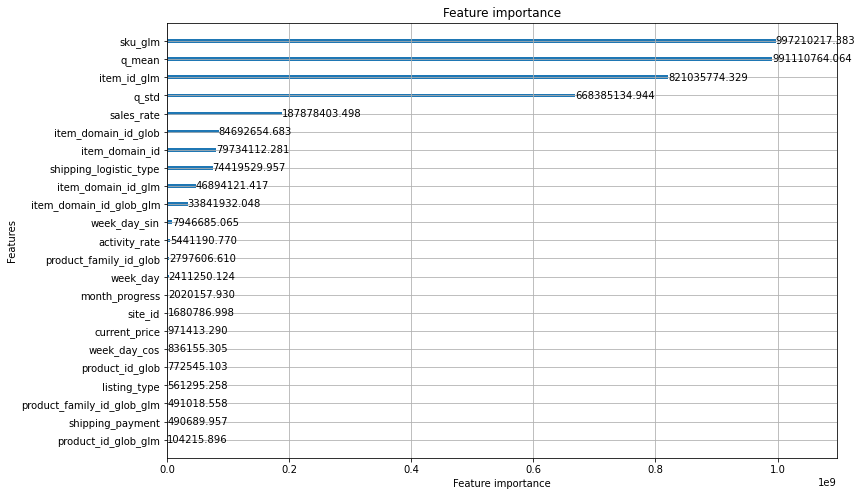

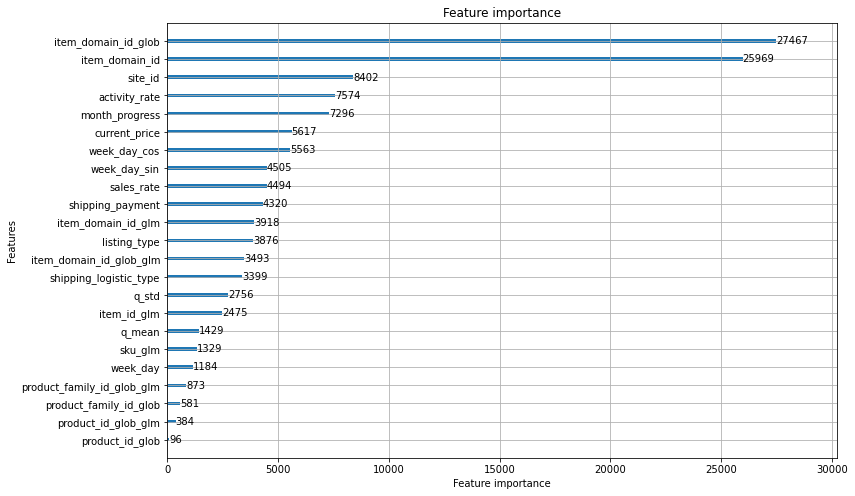

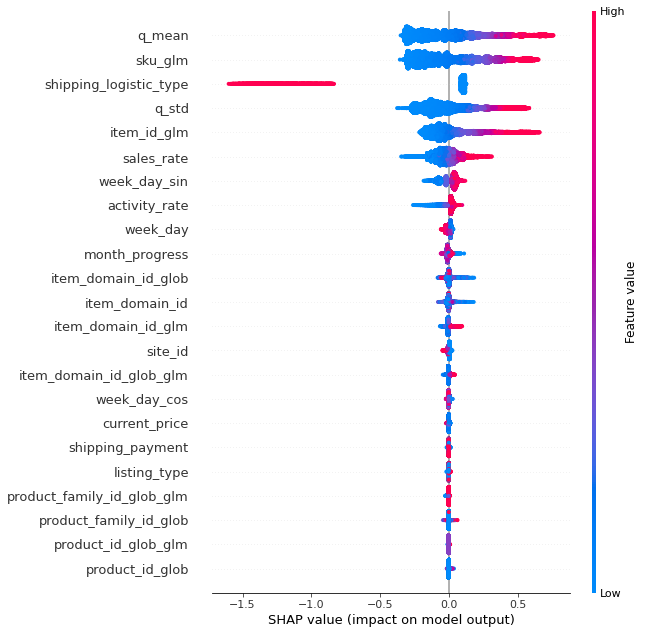

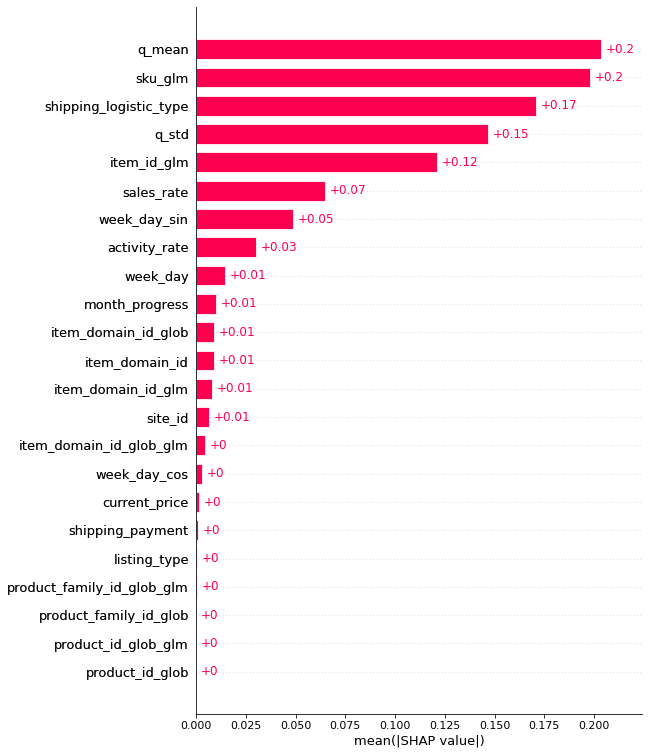

Elapsed time for training the model: 43.426532125473024 min.


In [13]:
if ASSESS:
    
    tic = time.time()
    train_data = dataset.copy()
    valid_idx = train_data.query("ds > '2021-03-01'").index

    model = LightGBMForecaster(**model_kwargs)
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")


    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    model.fit(fit_kwargs={"verbose_eval":20, "feval":evaluator.evaluate})

    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
    lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
    plt.show()
    explainer = shap.Explainer(model.model.model)
    shap_values = explainer(model.valid_features[model.input_features].sample(30000))
    shap.plots.beeswarm(shap_values, max_display=23, show=True)
    shap.plots.bar(shap_values, max_display=23, show=True)

    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

In [14]:
%%time  
if ASSESS:
    oof = model.predict(dataset.query("ds > '2021-03-01'"), recursive=False)

CPU times: user 30min 26s, sys: 26.2 s, total: 30min 52s
Wall time: 5min 9s


In [15]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.829511
MLB    0.881402
MLM    0.862219
Name: rmsse, dtype: float64

In [16]:
if ASSESS:
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

***
## Assessment of invetory days prediction

In [17]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"))
    predictor.fit(oof)

100%|██████████| 482635/482635 [01:18<00:00, 6156.00it/s]


In [18]:
if ASSESS:
    valid = (
        pd.read_csv(f"{input_path}/validation_seed2_harder.csv")
        .query("sku in @skus_assess_m1")
        .reset_index(drop=True)
    )

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)
    valid["days_to_stockout_disc"] = valid["days_to_stockout"].astype(int)

100%|██████████| 482635/482635 [01:18<00:00, 6177.30it/s]


RMSE (mean):  9.505986957309112
MAE (mean):  7.0417730338682905
MAE (median):  5.04288850898177



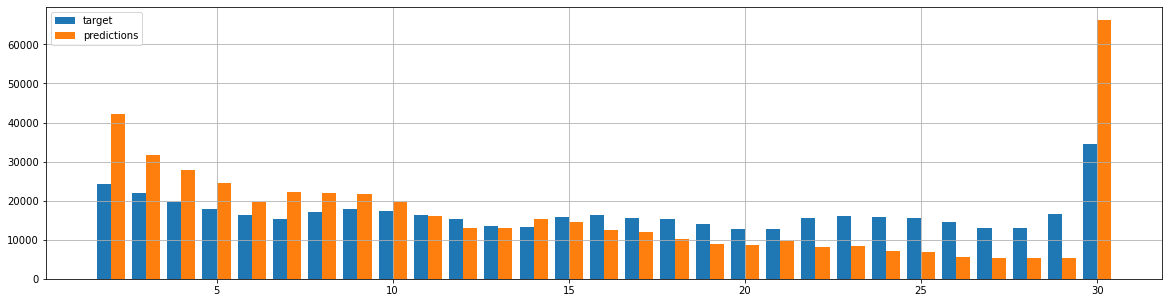

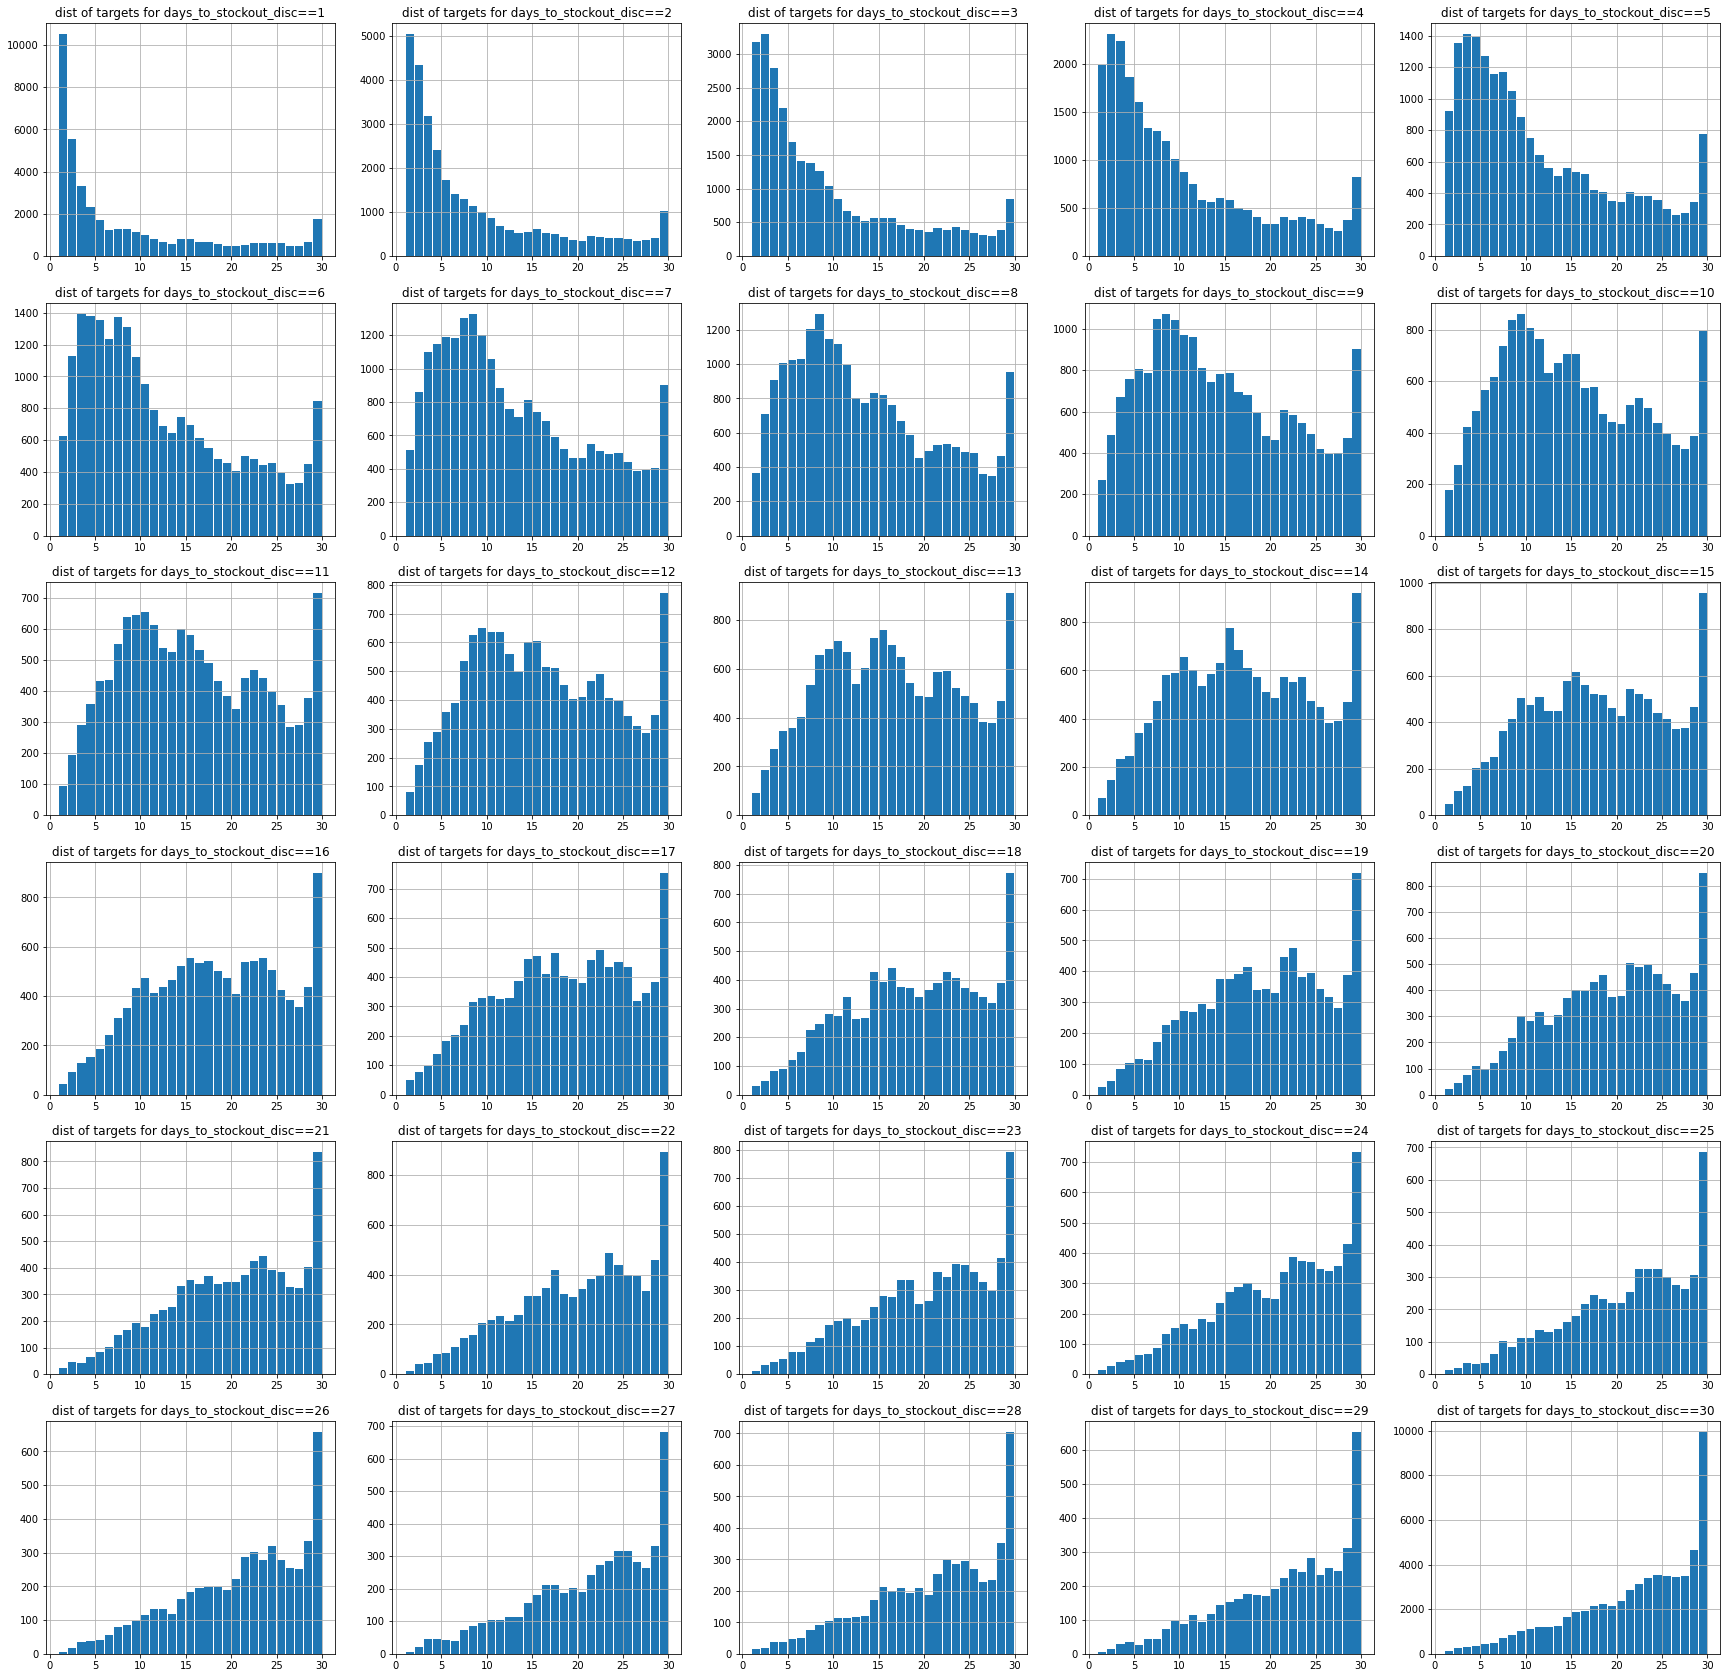

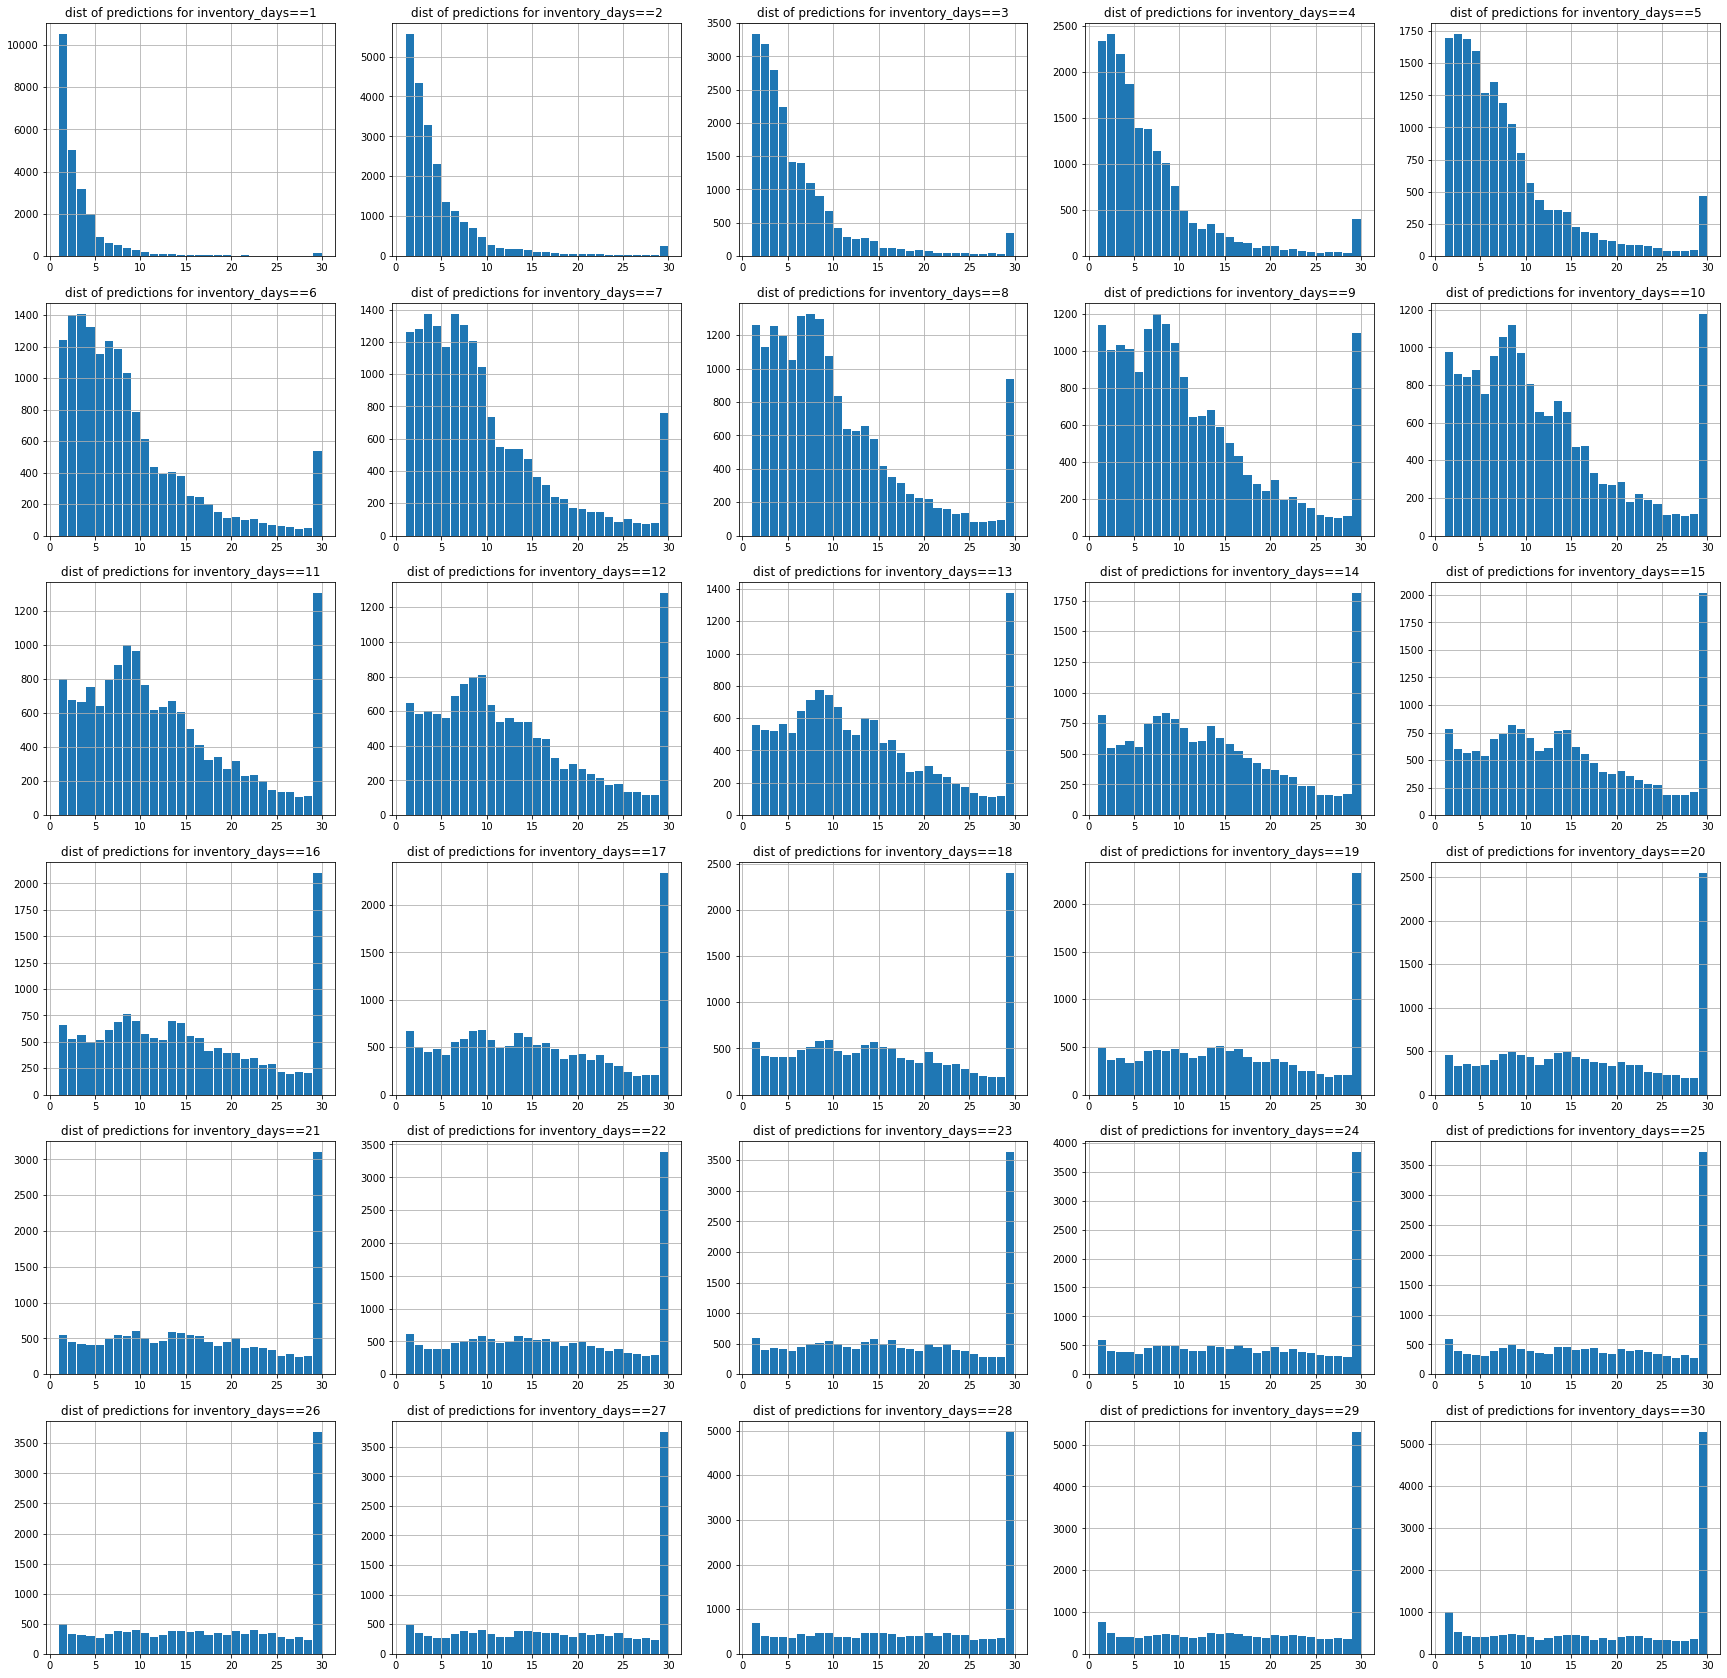

In [19]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("inventory_days <= 31").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("inventory_days <= 31").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("inventory_days <= 31").inventory_days, 
         valid.query("inventory_days <= 31").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("days_to_stockout_disc==@d").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("inventory_days==@d").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

RMSE (mean):  8.787713133834545
MAE (mean):  6.555846417546868
MAE (median):  4.876324608711072



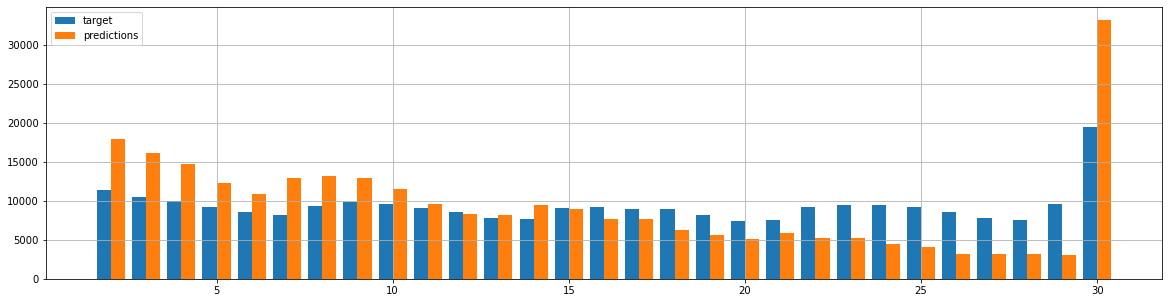

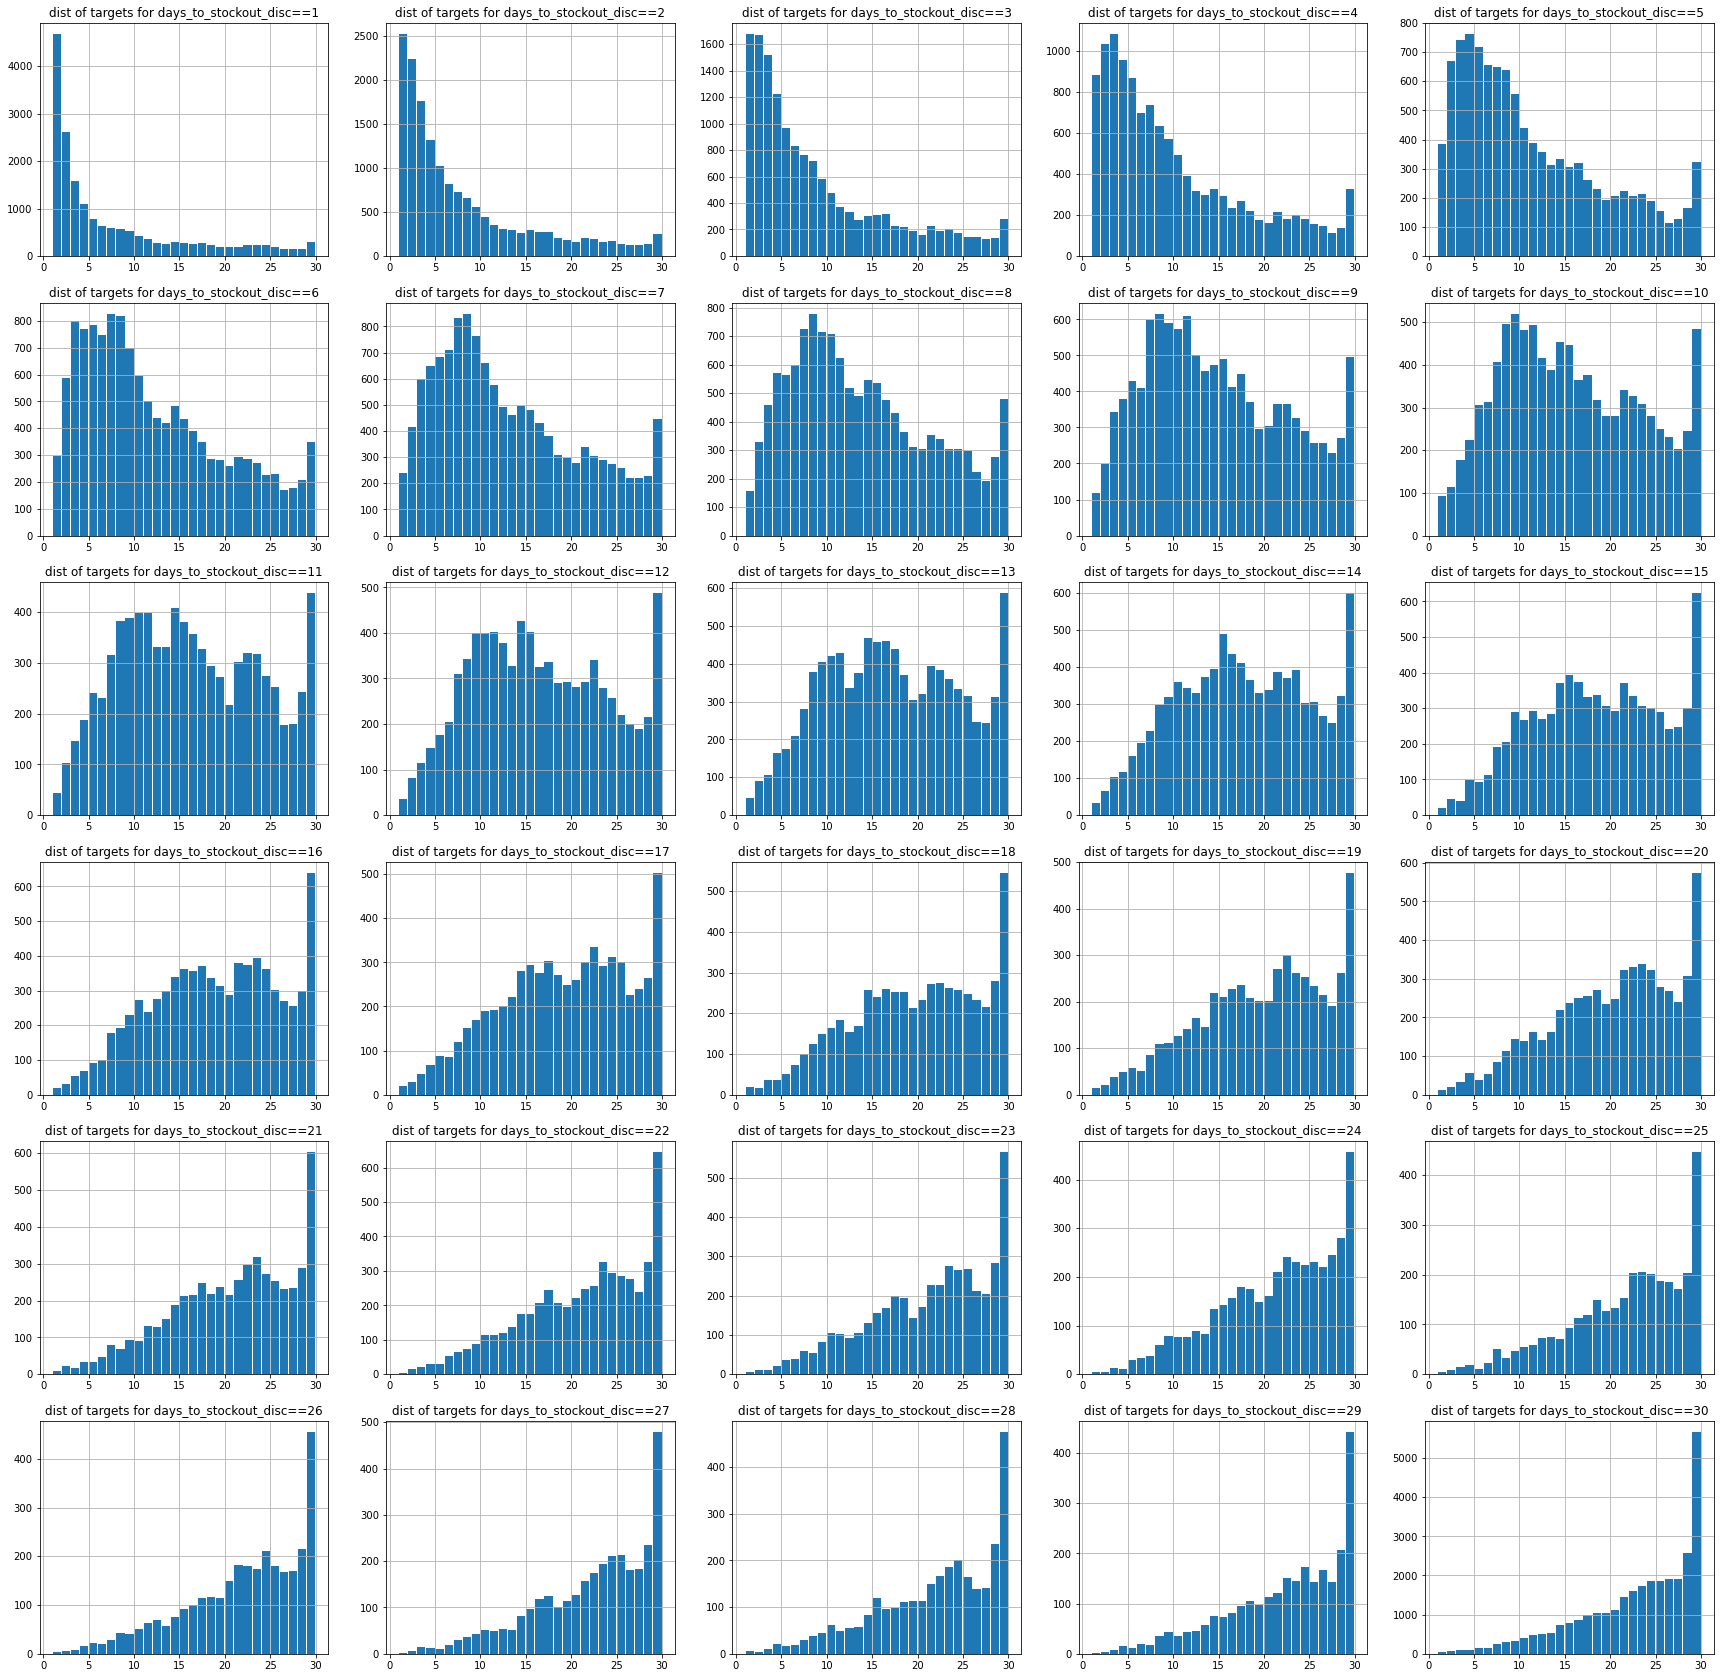

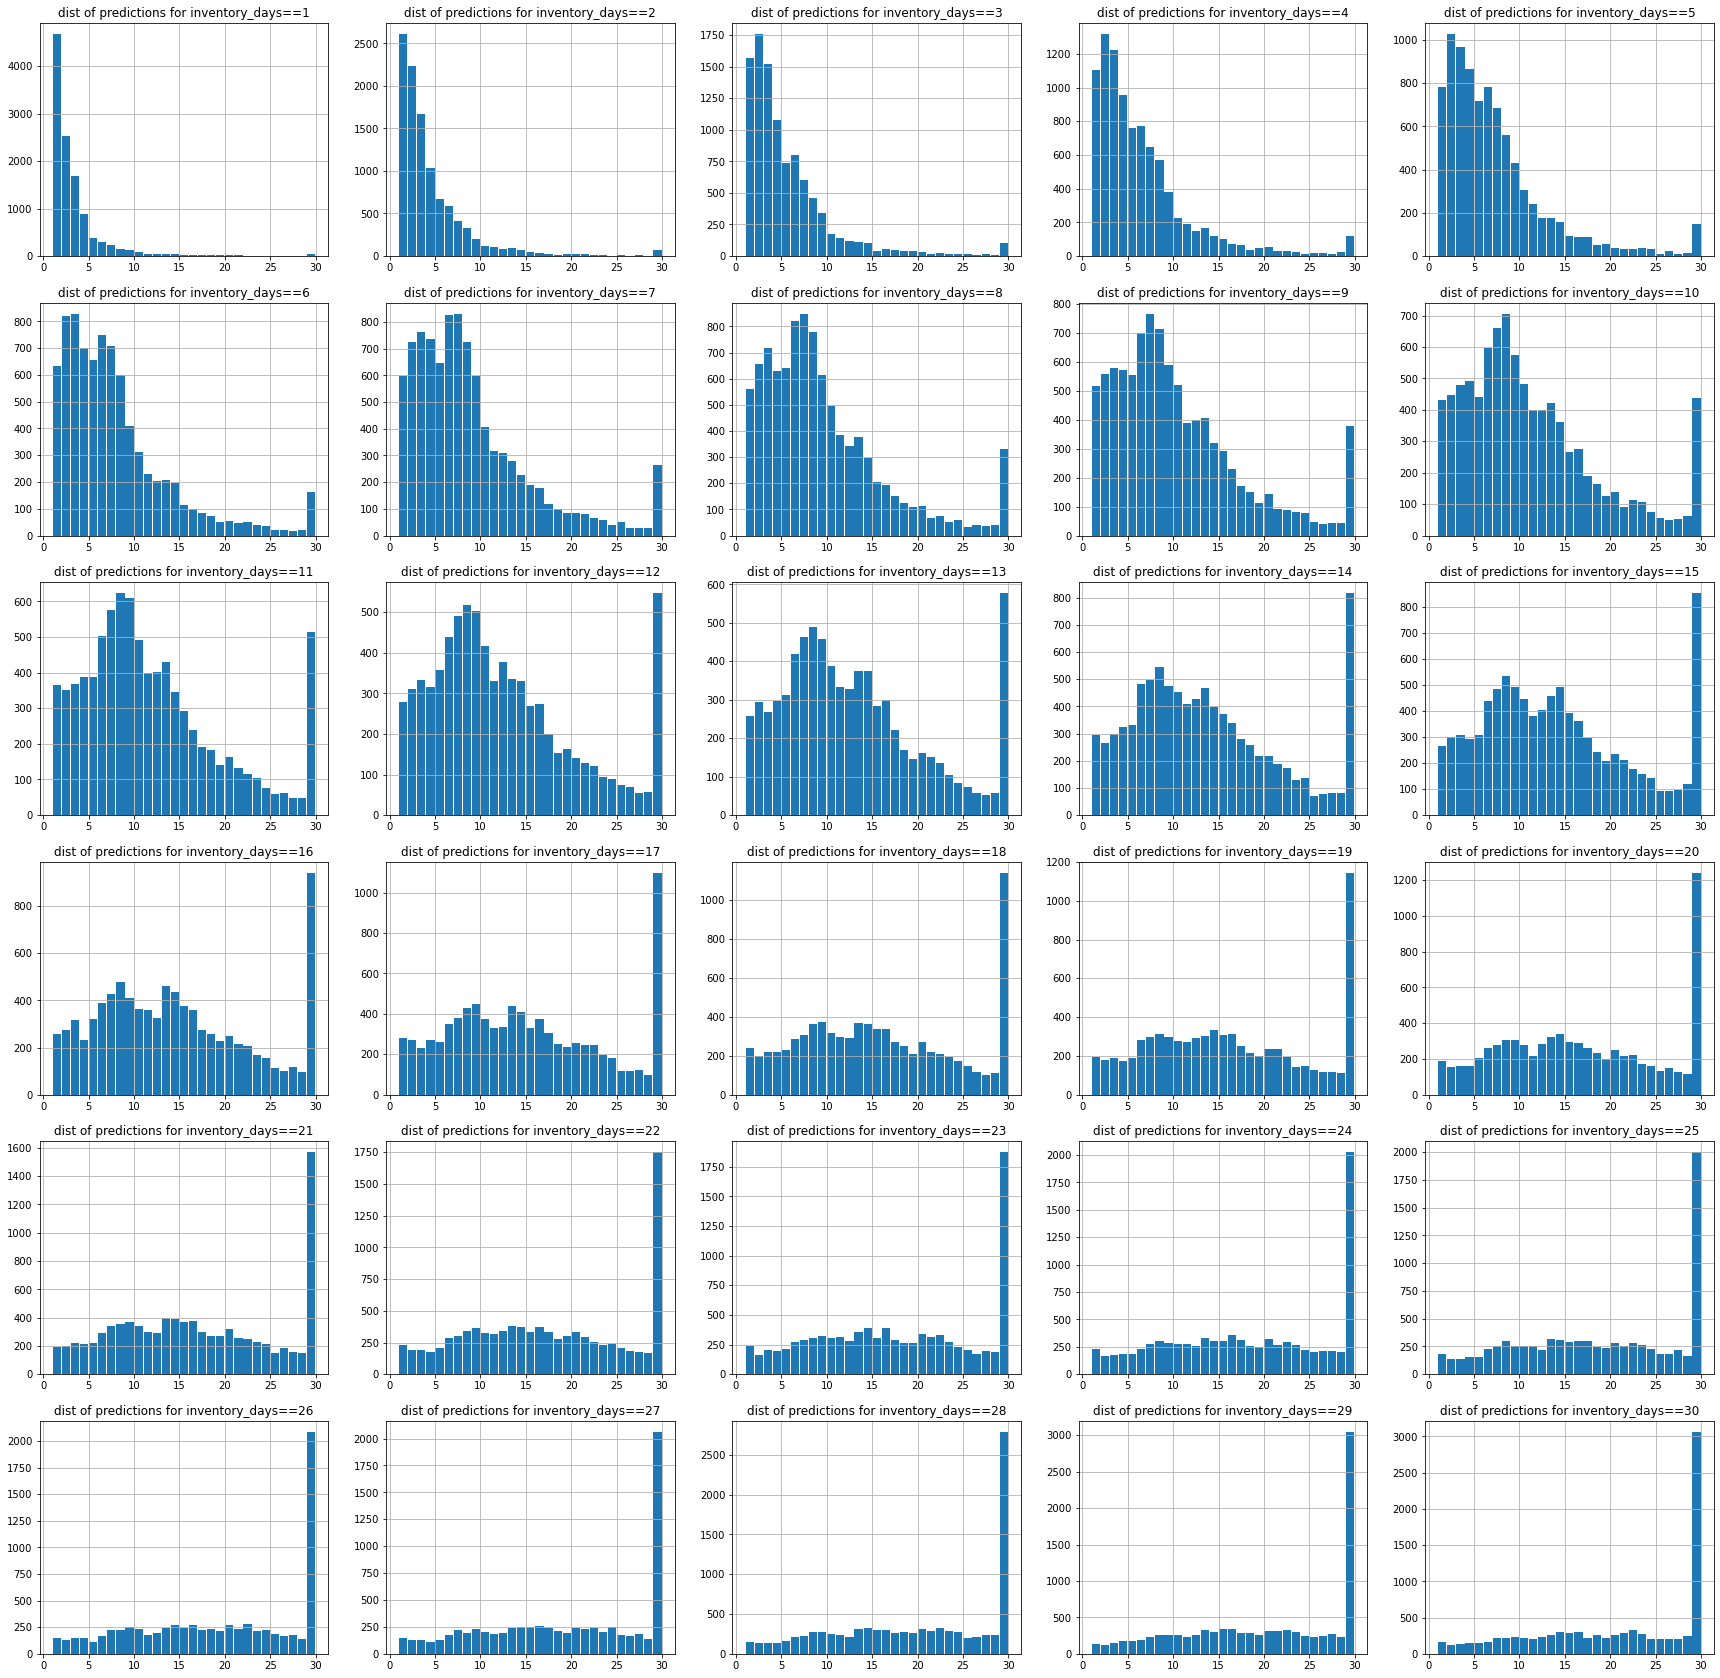

In [20]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )
    print()
    
    plt.figure(figsize=(20,5))
    plt.hist(
        [valid.query("sku in @skus_assess_m2").inventory_days, 
         valid.query("sku in @skus_assess_m2").days_to_stockout,
        ],
        label=["target","predictions"],
        bins=np.arange(1,31,1),
        align="right",
        rwidth=0.8)
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(days_to_stockout_disc == @d) & (sku in @skus_assess_m2)").inventory_days, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of targets for days_to_stockout_disc=={d}")
        plt.grid()
    plt.show()
    print()
    
    plt.figure(figsize=(30,30))
    for d in range(1,31):
        plt.subplot(6, 5, d)
        plt.hist(valid.query("(inventory_days == @d) & (sku in @skus_assess_m2)").days_to_stockout, bins=np.arange(1,31,1), rwidth=0.9)
        plt.title(f"dist of predictions for inventory_days=={d}")
        plt.grid()
    plt.show()

***
## Assessment of RPS

In [22]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()

print(dist_config)

{'lambda1': 1.6842502030985615, 'lambda2': 0.3677507495760691, 'lambda3': 0.5635636515917665, 'lambda4': 0.022595175543313962}


In [23]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_*.csv") if ("seed23" in fn or "real" in fn)]
    results = list()

    for files in valid_files:
        valid = (
            pd.read_csv(files)
            .query("sku in @skus_assess_m1")
            .query("inventory_days <= 30")
            .reset_index(drop=True)
        )
        valid["inventory_days"] = valid["inventory_days"].astype(int)
        
        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
                lambda3=dist_config["lambda3"],
                lambda4=dist_config["lambda4"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 482635/482635 [03:00<00:00, 2674.00it/s]


{'file': 'validation_seed23_harder', 'rps': 4.3597496484297}


100%|██████████| 482635/482635 [02:56<00:00, 2739.30it/s]


{'file': 'validation_seed23', 'rps': 4.104099114717726}


100%|██████████| 324347/324347 [01:59<00:00, 2709.08it/s]


{'file': 'validation_realstock', 'rps': 3.892019827010741}


In [24]:
if ASSESS:
    display(pd.DataFrame(results))

,file,rps
0,validation_seed23_harder,4.359750
1,validation_seed23,4.104099
2,validation_realstock,3.892020


In [25]:
del model, predictor, dataset
gc.collect()

44

***
## model training

In [26]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")
skus_for_test = pd.read_csv(f"{input_path}/test_data.csv").sku.values

dataset = (
    pd.read_parquet(f"{input_path}/train-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .query("sku in @skus_for_test")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

with open("../encoders/encoder-stg2.dill", "rb") as file:
    encoder = dill.load(file)
    file.close()

transformed = encoder.transform(dataset[encoder.cols].astype("category"))
for col in transformed.columns:
    dataset[col+"_glm"] = transformed[col].values

nrows: 30.218397
nskus: 526158


In [27]:
test = (
    pd.read_parquet(f"{input_path}/test-m1.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .assign(weight = None)
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

transformed = encoder.transform(test[encoder.cols].astype("category"))
for col in transformed.columns:
    test[col+"_glm"] = transformed[col].values

nrows: 15.78474
nskus: 526158


In [28]:
raw = pd.read_parquet(f"{input_path}/train_data.parquet", columns=["sku", "date", "sold_quantity", "minutes_active"])
metadata = pd.read_csv(f"{input_path}/metadata.csv", usecols=["sku","item_domain_id","site_id"])
raw = pd.merge(raw, metadata, how="inner", on="sku")

# compute q_mean and q_std features (w/o leakage)
feat = Featurador(raw)
feat.fit(left_limit="2021-02-01", right_limit="2021-03-31")

dataset = feat.transform(dataset)
test = feat.transform(test)

In [29]:
raw["had_sales"] = raw.eval("sold_quantity > 0")
raw["was_active"] = raw.eval("minutes_active > 120")

sales_rate = (raw.groupby("sku")["had_sales"].sum() / raw.groupby("sku")["date"].count()).reset_index(name="sales_rate")
activity_rate = (raw.groupby("sku")["was_active"].sum() / raw.groupby("sku")["date"].count()).reset_index(name="activity_rate")

dataset = (
    dataset
    .merge(sales_rate, how="inner", on="sku")
    .merge(activity_rate, how="inner", on="sku")
)

test = (
    test
    .merge(sales_rate, how="inner", on="sku")
    .merge(activity_rate, how="inner", on="sku")
)

In [30]:
min_weight = 0.2
scaler = preprocessing.MinMaxScaler(feature_range=(min_weight, 1))
dataset["weight"] = scaler.fit_transform(dataset["minutes_active"].values.reshape(-1,1)).ravel()

Mem. usage decreased to 3948.14 Mb (44.8% reduction)
Elapsed time for processing features: 3.4636529366175335 min.
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbrt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbrt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Total Bins 43096
[LightGBM] [Info] Number of data points in the train set: 30218397, number of used features: 23


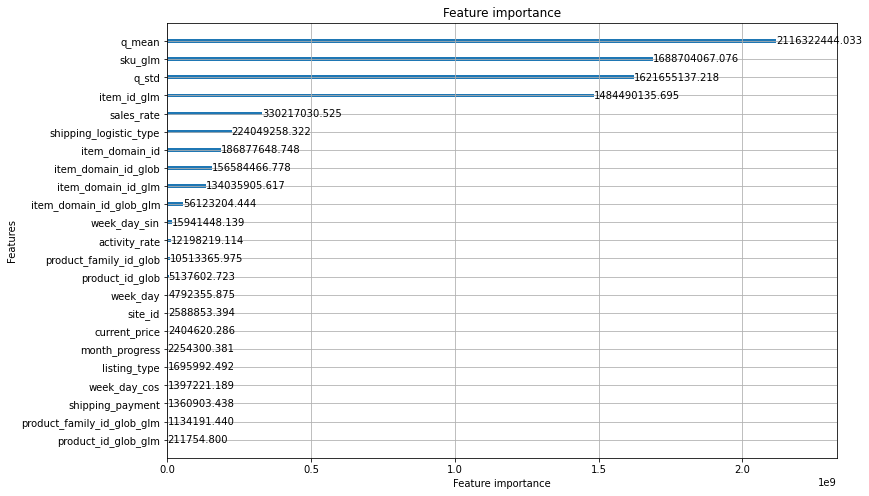

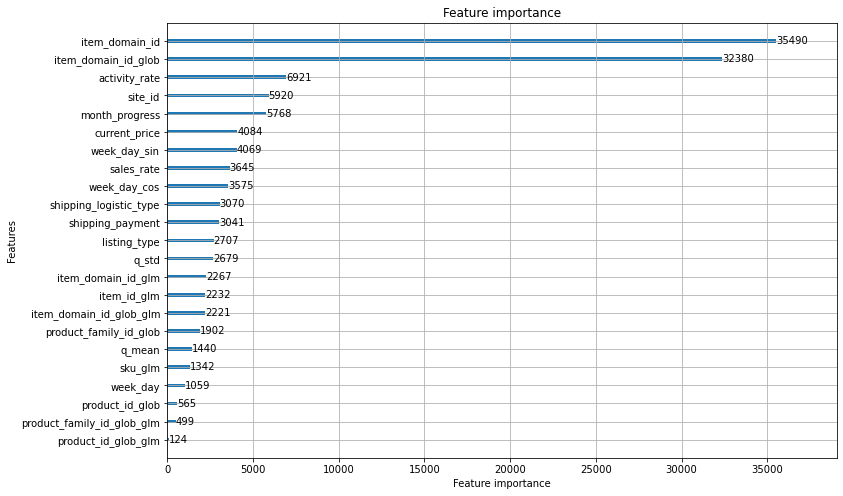

Elapsed time for training the model: 53.727487663427986 min.


In [31]:
tic = time.time()

model = LightGBMForecaster(**model_kwargs)
model.prepare_features(dataset)
model.train_features = reduce_mem_usage(model.train_features, verbose=True)
gc.collect()
tac = time.time()
print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

tic = time.time()
model.fit()
lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="gain")
lgb.plot_importance(model.model.model, figsize=(12,8), importance_type="split")
plt.show()
tac = time.time()
print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [32]:
test["weight"] = None
predictions = model.predict(test, recursive=False)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

In [33]:
predictor = InventoryDaysPredictor(dataset)
predictor.fit(predictions)

100%|██████████| 526158/526158 [01:32<00:00, 5672.41it/s]


In [34]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

100%|██████████| 526158/526158 [01:27<00:00, 5990.14it/s]


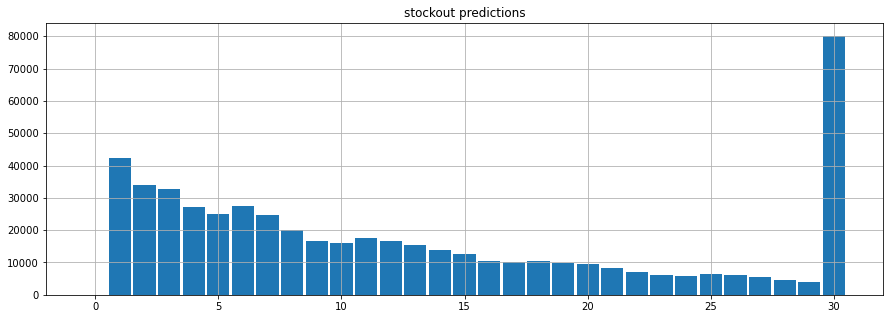

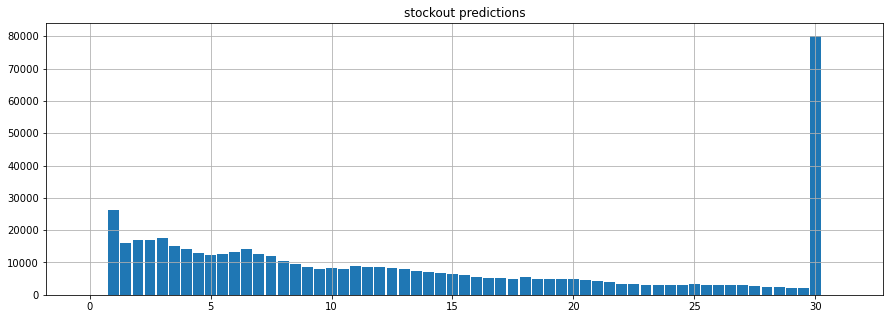

In [35]:
plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,1), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

plt.figure(figsize=(15,5))
plt.hist(stockout_preds.days_to_stockout, bins=np.arange(0,32,0.5), rwidth=0.9, align='left')
plt.grid()
plt.title("stockout predictions")
plt.show()

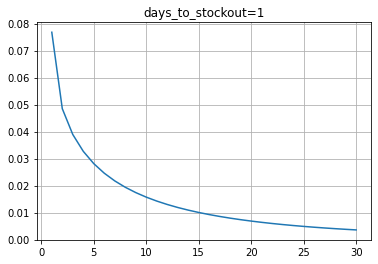

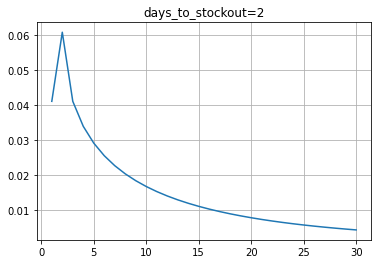

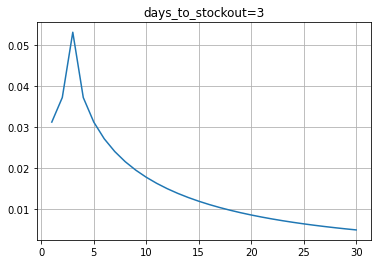

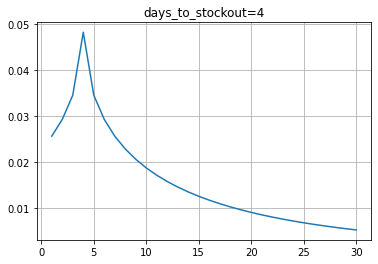

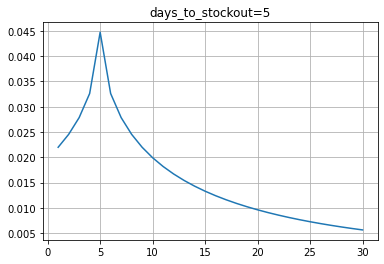

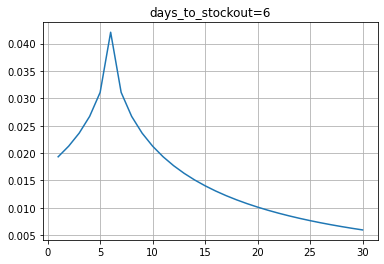

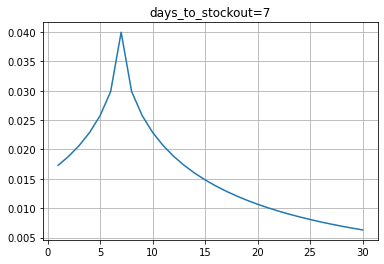

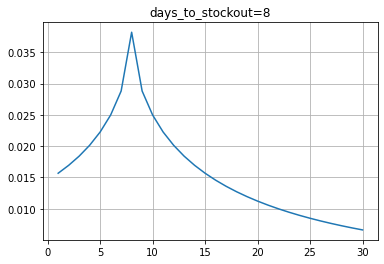

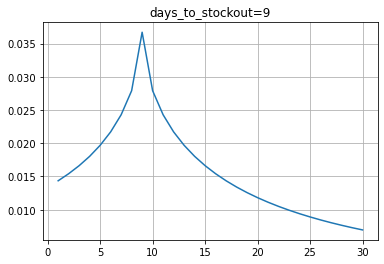

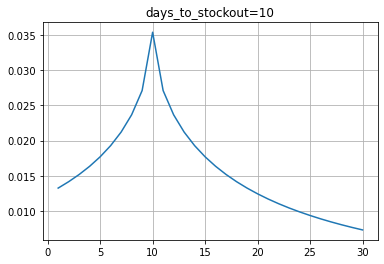

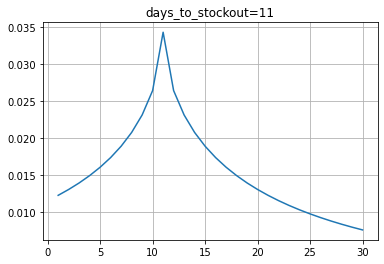

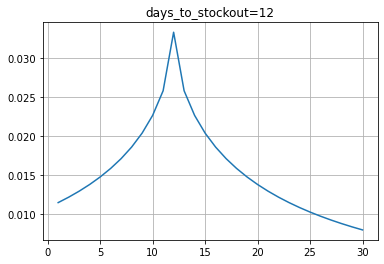

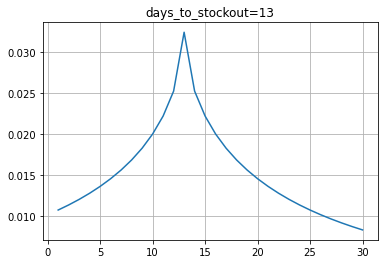

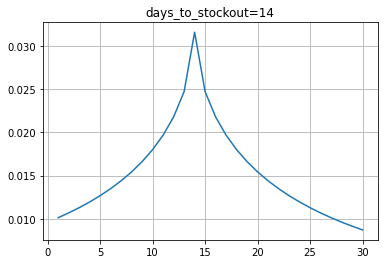

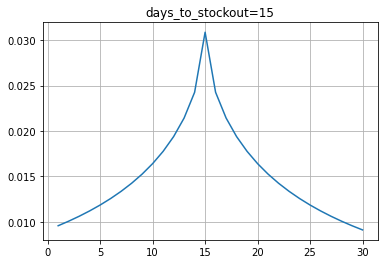

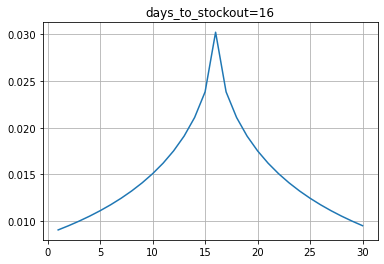

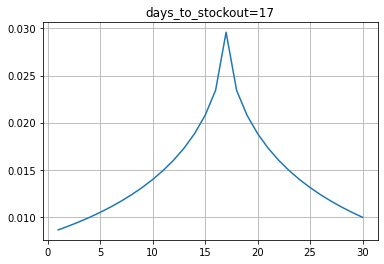

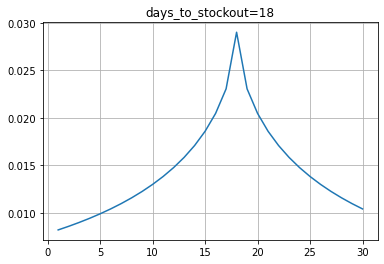

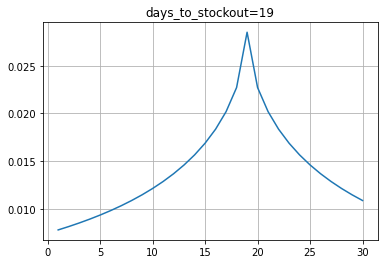

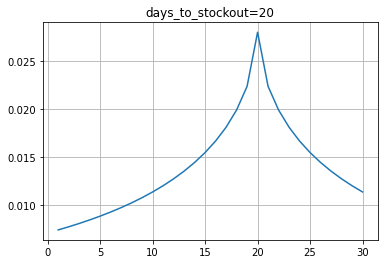

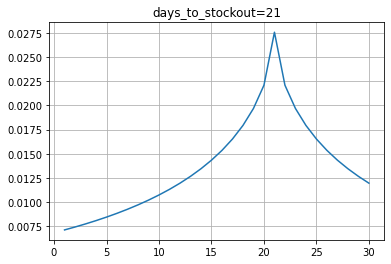

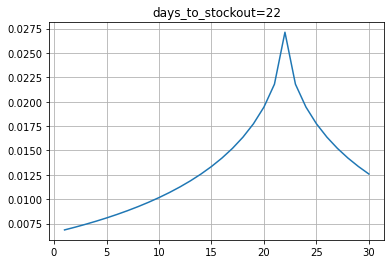

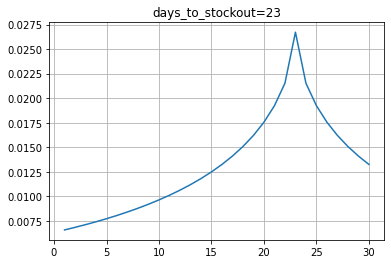

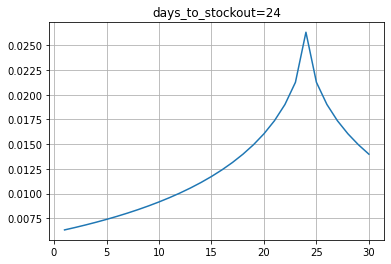

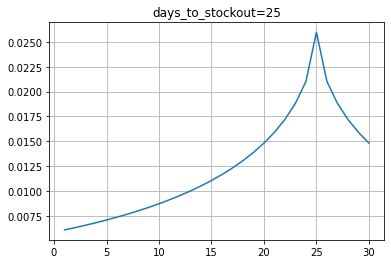

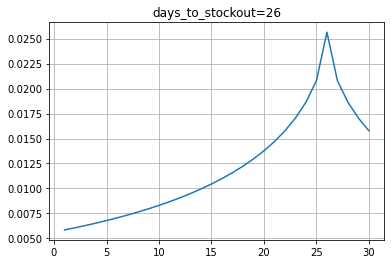

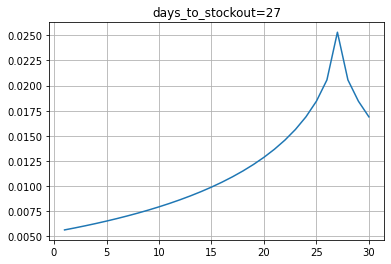

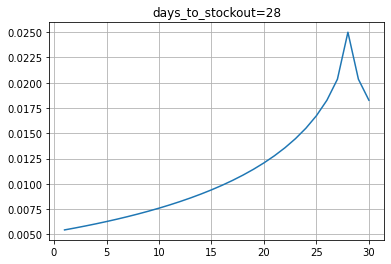

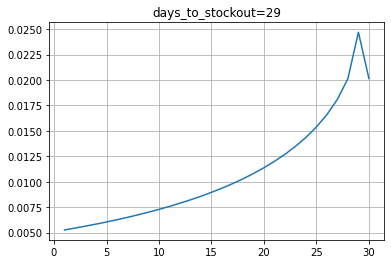

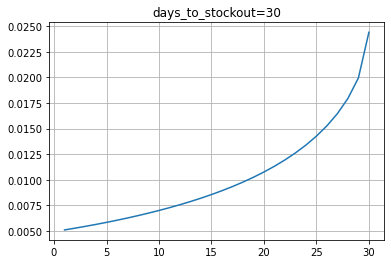

In [36]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    beta = dist_config["lambda3"]*(days_to_stockout**dist_config["lambda4"])
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [37]:
# skus = list()
# preds_proba = list()
# groups = (
#     test[["sku","target_stock"]]
#     .drop_duplicates()
#     .groupby("sku")
# )

# for sku,df in tqdm(groups):
#     skus.append(sku)
#     preds_proba.append(predictor.predict_proba(
#         sku, 
#         stock=df.target_stock.values[0],
#         lambda1=dist_config["lambda1"], 
#         lambda2=dist_config["lambda2"],
#         lambda3=dist_config["lambda3"],
#         lambda4=dist_config["lambda4"],
#     ))
# preds_proba = np.array(preds_proba)
# preds_proba = pd.DataFrame(preds_proba, index=skus)

In [38]:
# unpreds_proba = np.ones((len(unpredictable),30)) / 30
# unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

# preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
# preds_proba_mrg

***
## generate submission

In [39]:
# test = pd.read_csv(f"{input_path}/test_data.csv")
# preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [40]:
# assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
# assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
# assert preds_proba_mrg.max(axis=1).max() < 1

In [41]:
# (preds_proba_mrg
#  .round(4)
#  .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
# )

***